# Deep learning from scratch

# Learning objectives of the notebook

- Extend the ideas developed in the previous notebook to build a neural network using functions;
- Implement functions for the initialization of, forward propagation through, and updating of a neural network;
- Apply the logic of backpropagation in more detail;
- Hand-code gradient descent using `numpy` for a more realistic size of problem.

Having spent spent some time working on the ideas of supervised learning and getting familiar with the terminology of neural networks, let's write some code to implement a neural network from scratch. We're going to use a functional programming style to help build intuition. To make matters easier, we'll use a dictionary called `model` to store all data associated with the neural network (the weight matrices, the  bias vectors, etc.) and pass that into functions as a single argument. We'll also assume that the activation functions are the same in all the layers (i.e., the *logistic* or *sigmoid* function) to simplify the implementation. Production codes usually use an object-oriented style to build networks and, of course, are optimized for efficiency (unlike what we'll develop here).

We're going to borrow notation from Michael Neilsen's [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com) to make life easier. In particular, we'll let $W^\ell$ and $b^\ell$ denote the weight matrices & bias vectors respectively associated with the $\ell$th layer of the network. The entry $W^{\ell}_{jk}$ of $W^\ell$ is the weight parameter associated with the link connecting the $k$th neuron in layer $\ell-1$ to the $j$th neuron in layer $\ell$:

[![](../img/tikz16.png)](http://neuralnetworksanddeeplearning.com/chap2.html)

Let's put this altogether now and construct a network from scratch. We start with some typical imports.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1. Create an initialization function to set up model

Rather than the fixed constants in `setup` from before, write a function `initialize_model` that accepts a list  `dimensions` of positive integer inputs that constructs a `dict` with specific key-value pairs:
+ `model['nlayers']` : number of layers in neural network
+ `model['weights']` : list of NumPy matrices with appropriate dimensions
+ `model['biases']` : list of NumPy (column) vectors of appropriate dimensions
+ The matrices in `model['weights']` and the vectors in `model['biases']` should be initialized as randomly arrays of the appropriate shapes.

If the input list `dimensions` has `L+1` entries, the number of layers is `L` (the first entry of `dimensions` is the input dimension, the next ones are the number of units/neurons in each subsequent layer going up to the output layer).
Thus, for example:

```python
>>> dimensions = [784, 15, 10]
>>> model = initialize_model(dimensions)
>>> for k, (W, b) in enumerate(zip(model['weights'], model['biases'])):
>>>    print(f'Layer {k+1}:\tShape of W{k+1}: {W.shape}\tShape of b{k+1}: {b.shape}')
```
```
Layer 1:	Shape of W1: (15, 784)	Shape of b1: (15, 1)
Layer 2:	Shape of W2: (10, 15)	Shape of b2: (10, 1)
```

In [2]:
def initialize_model(dimensions):
    '''Accepts a list of positive integers; returns a dict 'model' with key/values as follows:
      model['nlayers'] : number of layers in neural network
      model['weights'] : list of NumPy matrices with appropriate dimensions
      model['biases'] : list of NumPy (column) vectors of appropriate dimensions
    These correspond to the weight matrices & bias vectors associated with each layer of a neural network.'''
    weights, biases = [], []
    L = len(dimensions) - 1 # number of layers (i.e., excludes input layer)
    for l in range(L):
        W = np.random.randn(dimensions[l+1], dimensions[l])
        b = np.random.randn(dimensions[l+1], 1)
        weights.append(W)
        biases.append(b)
    return dict(weights=weights, biases=biases, nlayers=L)

In [3]:
dimensions = [784, 15, 10]
model = initialize_model(dimensions)
print(model.keys())

dict_keys(['weights', 'biases', 'nlayers'])


## 2. Implement activation function(s), loss functions, & their derivatives
For today's purposes, we'll use only the *logistic* or *sigmoid* function as an activation function:
$$ \sigma(x) = \frac{1}{1+\exp(-x)} = \frac{\exp(x)}{1+\exp(x)}.$$
A bit of calculus shows that
$$ \sigma'(x) = \sigma(x)(1-\sigma(x)) .$$

Actually, a more numerically robust formula for $\sigma(x)$ (i.e., one that works for large positive or large negative input equally well) is
$$
\sigma(x) = \begin{cases} \frac{1}{1+\exp(-x)} & (x\ge0) \\ 1 - \frac{1}{1+\exp(x)} & \mathrm{otherwise} \end{cases}.
$$

For the loss function, we'll use the typical "$L_2$-norm of the error" (alternatively called *mean-square error (MSE)* when averaged over a batch of values:
$$ \mathcal{E}(\hat{y},y) = \frac{1}{2} \|\hat{y}-y\|^{2} = \frac{1}{2} \sum_{k=1}^{d} \left[ \hat{y}_{k}-y_{k} \right]^{2}.$$
Again, using multivariable calculus, we can see that
$$\nabla_{\hat{y}} \mathcal{E}(\hat{y},y) = \hat{y} - y.$$

Implement all four of these functions below.

In [4]:
def sigma(x):
    '''The logistic function; accepts arbitrary arrays as input (vectorized)'''
    return np.where(x>=0, 1/(1+np.exp(-x)), 1 - 1/(1+np.exp(x))) # piecewise for numerical robustness
def sigma_prime(x):
    '''The *derivative* of the logistic function; accepts arbitrary arrays as input (vectorized)'''
    return sigma(x)*(1-sigma(x)) # Derivative of logistic function

In [5]:
def loss(yhat, y):
    '''The loss as measured by the L2-norm squared of the error'''
    return 0.5 * np.square(yhat-y).sum()
def loss_prime(yhat, y):
    '''Implementation of the gradient of the loss function'''
    return (yhat - y) # gradient w.r.t. yhat

## 3. Implement a function for forward propagation

Write a function `forward` that uses the architecture described in a `dict` as created by `initialize_model` to evaluate the output of the neural network for a given input *column* vector `x`.
+ Take $a^{0}=x$ from the input.
+ For $\ell=1,\dotsc,L$, compute & store the intermediate computed vectors $z^{\ell}=W^{\ell}a^{\ell-1}+b^{\ell}$ (the *weighted inputs*) and $a^{\ell}=\sigma\left(z^{\ell}\right)$ (the *activations*) in an updated dictionary `model`. That is, modify the input dictionary `model` so as to accumulate:
  + `model['activations']`: a list with entries $a^{\ell}$ for $\ell=0,\dotsc,L$
  + `model['z_inputs']`: a list with entries $z^{\ell}$ for $\ell=1,\dotsc,L$
+ The function should return the computed output $a^{L}$ and the modified dictionary `model`.
Notice that input `z` can be a matrix of dimension $n_{0} \times N_{\mathrm{batch}}$ corresponding to a batch of input vectors (here, $n_0$ is the dimension of the expected input vectors).

In [6]:
# Abstract process into function and run tests again.
def forward(x, model):
    '''Implementation of forward propagation through a feed-forward neural network.
       x : input array oriented column-wise (i.e., features along the rows)
       model : dict with same keys as output of initialize_model & appropriate lists in 'weights' & 'biases'
    The output dict model is the same as the input with additional keys 'z_inputs' & 'activations';
    these are accumulated to be used later for backpropagation. Notice the lists model['z_inputs'] &
    model['activations'] both have the same number of entries as model['weights'] & model['biases']
    (one for each layer).
    '''
    a = x
    activations = [a]
    zs = []
    for W, b in zip(model['weights'], model['biases']):
        z = W @ a + b
        a = sigma(z)
        zs.append(z)
        activations.append(a)
    model['activations'], model['z_inputs'] = activations, zs
    return (a, model)

In [15]:
dimensions = [784,15,10]

### Algorithm for backpropagation:

#### (optional reading for the mathematically brave)

The description here is based on the *wonderfully concise* description from Michael Neilsen's [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com/chap2.html). Neilsen has artfully crafted a summary using the bare minimum mathematical prerequisites. The notation elegantly summarises the important ideas in a way to make implementation easy in array-based frameworks like Matlab or NumPy. This is the best description I (Dhavide) know of that does this.

In the following, $\mathcal{E}$ is the loss function and the symbol $\odot$ is the [*Hadamard product*](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) of two conforming arrays; this is simply a fancy way of writing the usual element-wise product of arrays as computed by NumPy & is sometimes called the *Schur product*. This can be reformulated in usual matrix algebra for analysis.

Given a neural network with $L$ layers (not including the "input layer") described by an appropriate architecture:

1. Input $x$: Set the corresponding activation $a^{0} \leftarrow x$ for the input layer.
2. Feedforward: For each $\ell=1,2,\dotsc,L$, compute *weighted inputs* $z^{\ell}$ & *activations* $a^{\ell}$ using the formulas
$$
\begin{aligned}
z^{\ell} & \leftarrow  W^{\ell} a^{\ell-1} + b^{\ell}, \\
a^{\ell} & \leftarrow  \sigma\left( z^{\ell}\right)
\end{aligned}.
$$
3. Starting from the end, compute the "error" in the output layer $\delta^{L}$ according to the formula
$$
\delta^{L} \leftarrow \nabla_{a^{L}} \mathcal{E} \odot \sigma'\left(z^{L}\right)
$$

4. *Backpropagate* the "error" for $\ell=L−1\dotsc,1$ using the formula
$$
\delta^{\ell} \leftarrow \left[ W^{\ell+1}\right]^{T}\delta^{\ell+1} \odot \sigma'\left(z^{\ell}\right).
$$
5. The required gradients of the loss function $\mathcal{E}$ with respect to the parameters $W^{\ell}_{p,q}$ and $b^{\ell}_{r}$ can be computed directly from the "errors" $\left\{ \delta^{\ell} \right\}$ and the weighted inputs $\left\{ z^{\ell} \right\}$ according to the relations
$$
\begin{aligned}
   \frac{\partial \mathcal{E}}{\partial W^{\ell}_{p,q}} &= a^{\ell-1}_{q} \delta^{\ell}_{p} &&(\ell=1,\dotsc,L)\\
   \frac{\partial \mathcal{E}}{\partial b^{\ell}_{r}} &= \delta^{\ell}_{r} &&
\end{aligned}
$$

## 4. Implement a function for backward propagation

**This one is a freebie!**

Implement a function `backward` that implements the back-propagation algorithm to compute the gradients of the loss function $\mathcal{E}$ with respect to the weight matrices $W^{\ell}$ and the bias vectors $b^{\ell}$.
+ The function should accept a column vector `y` of output labels and an appropriate dictionary `model` as input.
+ The dict `model` is assumed to have been generated *after* a call to `forward`; that is, `model` should have keys `'w_inputs'` and `'activations'` as computed by a call to `forward`.
+ The result will be a modified dictionary `model` with two additional key-value pairs:
  + `model['grad_weights']`: a list with entries $\nabla_{W^{\ell}} \mathcal{E}$ for $\ell=1,\dotsc,L$
  + `model['grad_biases']`: a list with entries $\nabla_{b^{\ell}} \mathcal{E}$ for $\ell=1,\dotsc,L$
+ Notice the dimensions of the matrices $\nabla_{W^{\ell}} \mathcal{E}$ and the vectors $\nabla_{b^{\ell}} \mathcal{E}$ will be identical to those of ${W^{\ell}}$ and ${b^{\ell}}$ respectively.
+ The function's return value is the modified dictionary `model`.


We've done this for you (in the interest of time). Notice that input `y` can be a matrix of dimension $n_{L} \times N_{\mathrm{batch}}$ corresponding to a batch of output vectors (here, $n_L$ is the number of units in the output layer).

In [7]:
def backward(y, model):
    '''Implementation of backward propagation of data through the network
       y : output array oriented column-wise (i.e., features along the rows) as output by forward
       model : dict with same keys as output by forward
    Note the input needs to have keys 'nlayers', 'weights', 'biases', 'z_inputs', and 'activations'
    '''
    Nbatch = y.shape[1] # Needed to extend for batches of vectors
    # Compute the "error" delta^L for the output layer
    yhat = model['activations'][-1]
    z, a = model['z_inputs'][-1], model['activations'][-2]
    delta = loss_prime(yhat, y) * sigma_prime(z)
    # Use delta^L to compute gradients w.r.t b & W in the output layer.
    grad_b, grad_W = delta @ np.ones((Nbatch, 1)), np.dot(delta, a.T)
    grad_weights, grad_biases = [grad_W], [grad_b]
    loop_iterates = zip(model['weights'][-1:0:-1],
                        model['z_inputs'][-2::-1],
                        model['activations'][-3::-1])
    for W, z, a in loop_iterates:
        delta = np.dot(W.T, delta) * sigma_prime(z)
        grad_b, grad_W = delta @ np.ones((Nbatch, 1)), np.dot(delta, a.T)
        grad_weights.append(grad_W)
        grad_biases.append(grad_b)
    # We built up lists of gradients backwards, so we reverse the lists
    model['grad_weights'], model['grad_biases'] = grad_weights[::-1], grad_biases[::-1]
    return model

## 5. Implement a function to update the model parameters using computed gradients.

Given some positive learning rate $\eta>0$, we want to change all the weights and biases using their gradients.
Write a function `update` to compute a single step of gradient descent assuming that the model gradients have been computed for a given input vector.
+ The functions signature should be `update(eta, model)` where `eta` is a positive scalar value and `model` is a dictionary as output from `backward`.
+ The result will be an updated model with the values updated for `model['weights']` and `model['biases']`.
+ Written using array notations, these updates can be expressed as
   $$
   \begin{aligned}
   W^{\ell} &\leftarrow W^{\ell} - \eta \nabla_{W^{\ell}} \mathcal{E} &&(\ell=1,\dotsc,L)\\
   b^{\ell} &\leftarrow b^{\ell} - \eta \nabla_{b^{\ell}} \mathcal{E} &&
   \end{aligned}.
   $$
+ Written out component-wise, the preceding array expressions would be written as
   $$
   \begin{aligned}
      W^{\ell}_{p,q} &\leftarrow W^{\ell}_{p,q} - \eta \frac{\partial \mathcal{E}}{\partial W^{\ell}_{p,q}}
      &&(\ell=1,\dotsc,L)\\
      b^{\ell}_{r} &\leftarrow b^{\ell}_{r} - \eta \frac{\partial \mathcal{E}}{\partial b^{\ell}_{r}} &&
   \end{aligned}
   $$.
+ For safety, have the update step delete the keys added by calls to `forward` and `backward`, i.e., the keys `'z_inputs'`, `'activations'`, `'grad_weights'`, & `'grad_biases'`.
+ The output should be a dict `model` like before.

In [8]:
def update(eta, model):
    '''Use learning rate and gradients to update model parameters
       eta : learning rate (positive scalar parameter)
       model : dict with same keys as output by backward
    Output result is a modified dict model
    '''
    new_weights, new_biases = [], []
    for W, b, dW, db in zip(model['weights'], model['biases'], model['grad_weights'], model['grad_biases']):
        new_weights.append(W - (eta * dW))
        new_biases.append(b- (eta * db))
    model['weights'] = new_weights
    model['biases'] = new_biases
    # Get rid of extraneous keys/values
    for key in ['z_inputs', 'activations', 'grad_weights', 'grad_biases']:
        del model[key]
    return model

## 6. Implement steepest descent in a loop for random training data

Let's now attempt to use our NumPy-based model to implement the steepest descent algorithm. We'll explain these numbers shortly in the context of the MNIST digit classification problem.

+ Generate random arrays `X` and `y` of dimensions $28^2 \times N_{\mathrm{batch}}$ and $10\times N_{\mathrm{batch}}$ respectively where $N_{\mathrm{batch}}=10$.
+ Initialize the network architecture using `initialize_model` as above to require an input layer of $28^2$ units, a hidden layer of 15 units, and an output layer of 10 units.
+ Choose a learning rate of, say, $\eta=0.5$ and a number of epochs `n_epoch` of, say, $30$.
+ Construct a for loop with `n_epochs` iterations in which:
    + The output `yhat` is computed from the input`X` using `forward`.
    + The function `backward` is called to compute the gradients of the loss function with respect to the weights and biases.
    + Update the network parameters using the function `update`.
    + Compute and print out the epoch (iteration counter) and the value of the loss function.

In [9]:
N_batch = 10
n_epochs = 30
dimensions = [784, 15, 10]
X = np.random.randn(dimensions[0], N_batch)
y = np.random.randn(dimensions[-1], N_batch)
eta = 0.5
model = initialize_model(dimensions)

for epoch in range(n_epochs):
    yhat, model = forward(X, model)
    err = loss(yhat, y)
    print(f'Epoch: {epoch}\tLoss: {err}')
    model = backward(y, model)
    model = update(eta, model)

Epoch: 0	Loss: 56.93518157189513
Epoch: 1	Loss: 46.185688333319725
Epoch: 2	Loss: 44.30500741992865
Epoch: 3	Loss: 43.42197214793739
Epoch: 4	Loss: 42.74817041374757
Epoch: 5	Loss: 42.19285857512054
Epoch: 6	Loss: 41.754295971466185
Epoch: 7	Loss: 41.369371856888634
Epoch: 8	Loss: 40.96955225438356
Epoch: 9	Loss: 40.76088870589905
Epoch: 10	Loss: 40.59394755669327
Epoch: 11	Loss: 40.444111262232546
Epoch: 12	Loss: 40.30303698612012
Epoch: 13	Loss: 40.169348957516085
Epoch: 14	Loss: 40.028072982202225
Epoch: 15	Loss: 39.83248462582061
Epoch: 16	Loss: 39.31978555887973
Epoch: 17	Loss: 38.87527860779275
Epoch: 18	Loss: 38.53427953460131
Epoch: 19	Loss: 38.1706008762236
Epoch: 20	Loss: 37.898548341318914
Epoch: 21	Loss: 37.61807596673233
Epoch: 22	Loss: 37.31357136314796
Epoch: 23	Loss: 37.04579805770505
Epoch: 24	Loss: 36.74926618781042
Epoch: 25	Loss: 36.46855188390438
Epoch: 26	Loss: 36.279575494152795
Epoch: 27	Loss: 36.12783571947411
Epoch: 28	Loss: 35.99324279820415
Epoch: 29	Loss: 3

## 7. Modify the steepest descent loop to make a plot

Let's alter the preceding loop to accumulate selected epoch & loss values in lists for plotting.

+ Set `N_batch` and `n_epochs` to be larger, say, $50$ and $30,000$ respectively.
+ Change the preceding `for` loop so that:
    + The `epoch` counter and the loss value are accumulated into lists every, say, `SKIP` iterations where `SKIP==500`.
    + Eliminate the `print` statement(s) to save on output.
+ After the `for` loop terminates, make a `semilogy` plot to verify that the loss function is actually decreasing with sucessive epochs.
    + Use the list `epochs` to accumulate the `epoch` every 500 epochs.
    + Use the list `losses` to accumulate the values of the loss function every 500 epochs.

In [10]:
N_batch = 50
n_epochs = 30000
SKIP = 50
dimensions = [784, 15, 10]
X = np.random.randn(dimensions[0], N_batch)
y = np.random.randn(dimensions[-1], N_batch)
eta = 0.5
model = initialize_model(dimensions)

# accumulate the epoch and loss in these respective lists
epochs, losses = [], []
for epoch in range(n_epochs):
    yhat, model = forward(X, model)
    model = backward(y, model)
    model = update(eta, model)
    if (divmod(epoch, SKIP)[1]==0):
        err = loss(yhat, y)
        epochs.append(epoch)
        losses.append(err)

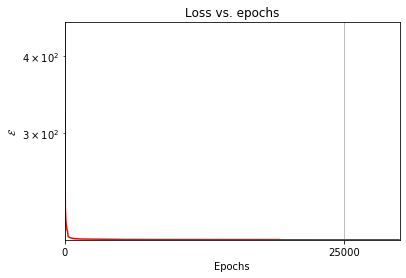

In [11]:
# code for plotting once that the lists epochs and losses are accumulated
fig = plt.figure(); ax = fig.add_subplot(111)
ax.set_xlim([0,n_epochs]); ax.set_ylim([min(losses), max(losses)]);
ax.set_xticks(epochs[::500]); ax.set_xlabel("Epochs"); ax.grid(True);
ax.set_ylabel(r'$\mathcal{E}$'); 
h1 = ax.semilogy(epochs, losses, 'r-', label=r'$\mathcal{E}$')
plt.title('Loss vs. epochs');